# Joint Pertub-seq perturbations analysis

In [ ]:
import os 
import sys
sys.path.append('../../..')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc

from causarray import prep_causarray_data, fit_gcate, LFC

The original data of Jin et al 2020 can be downloaded from the Broad single cell portal (https://singlecell.broadinstitute.org/single_cell/study/SCP1184).
Here, we just use a subset of the data to demonstrate the workflow of the analysis.

In [2]:
adata = sc.read_h5ad('perturbseq-exneu.h5ad')
adata

AnnData object with n_obs × n_vars = 2926 × 3221
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'NAME', 'nGene', 'nUMI', 'Cluster', 'Batch', 'CellType', 'Perturbation', 'isKey', 'isAnalysed', 'SCRUBLET'

For running causarray, we require the following inputs:

- `Y`: the cell-by-gene gene expression matrix.
- `A`: the cell-by-condition binary matrix of the perturbation/treatment conditions.
- `X, X_A`: (optional) the cell-by-covariate matrix of the covariates of interest for outcome and propensity models.

Here, `Y` and `A` can be dataframes.

In [3]:
Y = pd.DataFrame(adata.X.copy(), columns=adata.var.index)
A = pd.get_dummies(adata.obs['Perturbation'], columns=['Perturbation'], drop_first=False).drop(columns=['GFP'])

Y, A, X, X_A = prep_causarray_data(Y, A)
a = A.shape[1]
a

29

### Number of nonlinear factors

We can estimate the number of nonlinear factors using the following function.

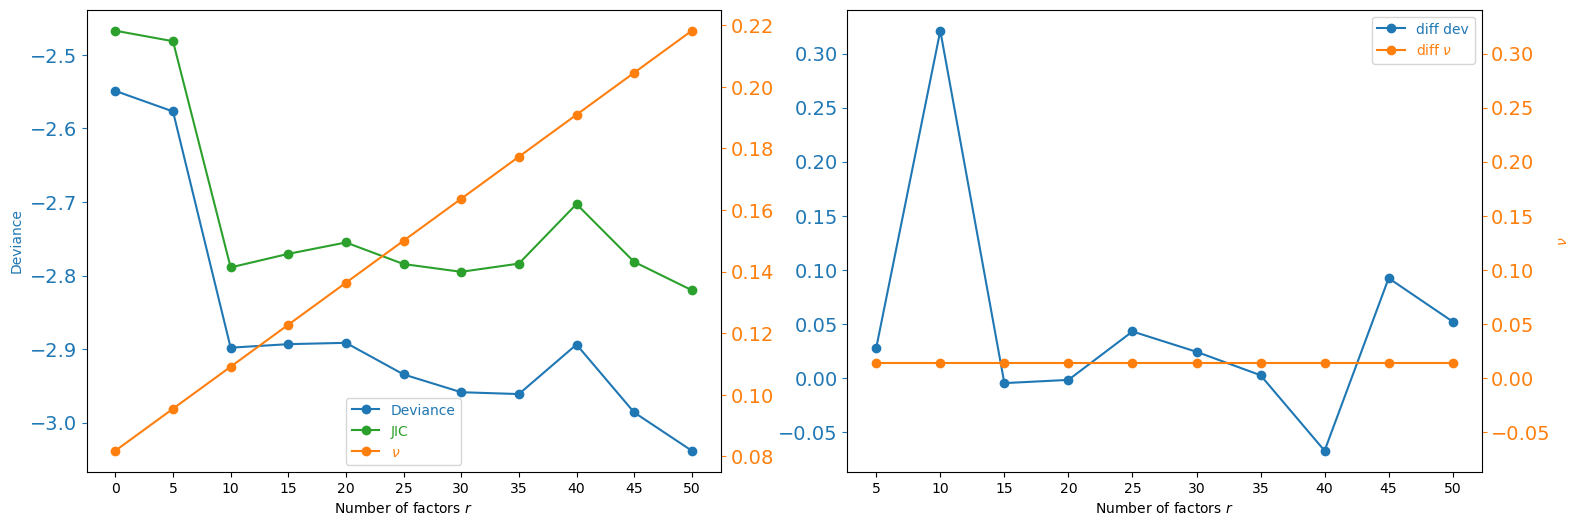

In [ ]:
from causarray import estimate_r, plot_r
# df_r = estimate_r(Y, X, A, np.arange(5,55,5))
# df_r.to_csv('perturbseq-r.csv', index=False)
df_r = pd.read_csv('perturbseq-r.csv')
fig = plot_r(df_r)

### Estimate unmeasured confounders

We first apply gcate to estimate unmeasured confounders.

In [4]:
r = 10
res_1, res_2 = fit_gcate(Y, X, A, r, verbose=True)
U = res_2['U']

'Estimating dispersion parameter...'
'Fitting poisson GLM with offset...'


100%|██████████| 3221/3221 [00:06<00:00, 461.94it/s]


{'d': 30, 'n': 2926, 'p': 3221, 'r': 10}
'Estimating initial latent variables with GLMs...'
'Fitting nb GLM with offset...'


100%|██████████| 3221/3221 [00:03<00:00, 894.94it/s]


'Estimating initial coefficients with GLMs...'
'Fitting nb GLM with offset...'


100%|██████████| 3221/3221 [00:17<00:00, 185.38it/s]


{'kwargs_es': {'max_iters': 500,
               'patience': 5,
               'tolerance': 0.001,
               'warmup': 0},
 'kwargs_glm': {'disp_glm': array([ 1.47414891,  3.00517016,  0.64800909, ..., 12.75504916,
       18.60623345, 11.39534142]),
                'family': 'nb',
                'size_factor': array([0.53193358, 0.87362742, 1.2235467 , ..., 0.5593801 , 0.73025856,
       0.77857223])},
 'kwargs_ls': {'C': 1000.0,
               'alpha': 0.1,
               'beta': 0.5,
               'max_iters': 20,
               'tol': 0.0001}}


  1%|          | 6/500 [00:28<38:27,  4.67s/it, Early stopped.Best Epoch: 0. Best Metric: 1.683583.]


{'d': 30, 'n': 2926, 'p': 3221, 'r': 10}
{'kwargs_es': {'max_iters': 500,
               'patience': 5,
               'tolerance': 0.001,
               'warmup': 0},
 'kwargs_glm': {'disp_glm': array([ 1.47414891,  3.00517016,  0.64800909, ..., 12.75504916,
       18.60623345, 11.39534142]),
                'family': 'nb',
                'size_factor': array([0.53193358, 0.87362742, 1.2235467 , ..., 0.5593801 , 0.73025856,
       0.77857223])},
 'kwargs_ls': {'C': 1000.0,
               'alpha': 0.1,
               'beta': 0.5,
               'max_iters': 20,
               'tol': 0.0001}}


 11%|█         | 54/500 [01:59<16:28,  2.22s/it, Early stopped.Best Epoch: 48. Best Metric: 1.700308.]


### Estimate log-fold change based on counterfactuals

Next, we apply causarray to estimate the causal effects of perturbations on gene expression.

In [5]:
offsets = np.log(res_2['kwargs_glm']['size_factor']) # use the precomputed size factors
df_res, estimation = LFC(Y, np.c_[X, U], A, np.c_[X_A, U], offset=offsets, verbose=True)

'Estimating LFC...'
{'a': 29, 'd': 11, 'd_A': 12, 'estimands': 'LFC', 'n': 2926, 'p': 3221}
{'C': 1.0,
 'class_weight': 'balanced',
 'fit_intercept': False,
 'random_state': 0}
{'offset': array([-0.63123664, -0.13510128,  0.20175377, ..., -0.58092607,
       -0.31435661, -0.25029351]),
 'random_state': 0}
'Fitting poisson GLM with offset...'


100%|██████████| 3221/3221 [00:05<00:00, 537.68it/s]


'Fitting nb GLM with offset...'


100%|██████████| 29/29 [00:00<00:00, 65.57it/s]


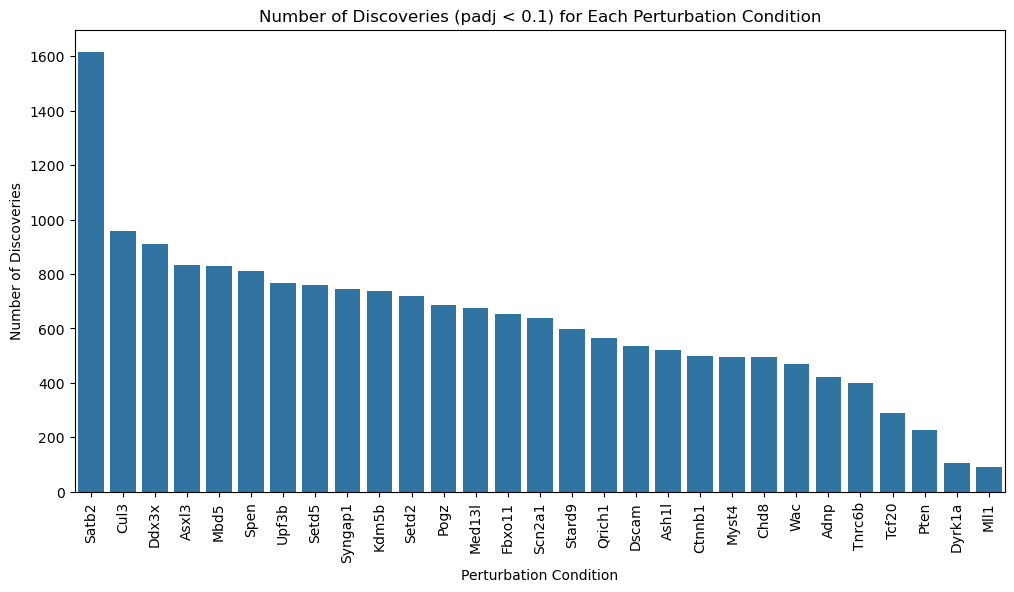

In [6]:
# Filter the results for significant discoveries
significant_discoveries = df_res[df_res['padj'] < 0.1]

# Count the number of discoveries for each perturbation condition
discovery_counts = significant_discoveries['trt'].value_counts().reset_index()
discovery_counts.columns = ['Perturbation', 'Count']

# Plot the number of discoveries for each perturbation condition
plt.figure(figsize=(12, 6))
sns.barplot(data=discovery_counts, x='Perturbation', y='Count')
plt.xticks(rotation=90)
plt.title('Number of Discoveries (padj < 0.1) for Each Perturbation Condition')
plt.xlabel('Perturbation Condition')
plt.ylabel('Number of Discoveries')
plt.show()

We can also inspect the distribution of propensity scores, to make sure the doubly-robust estimation procedure is reliable. 

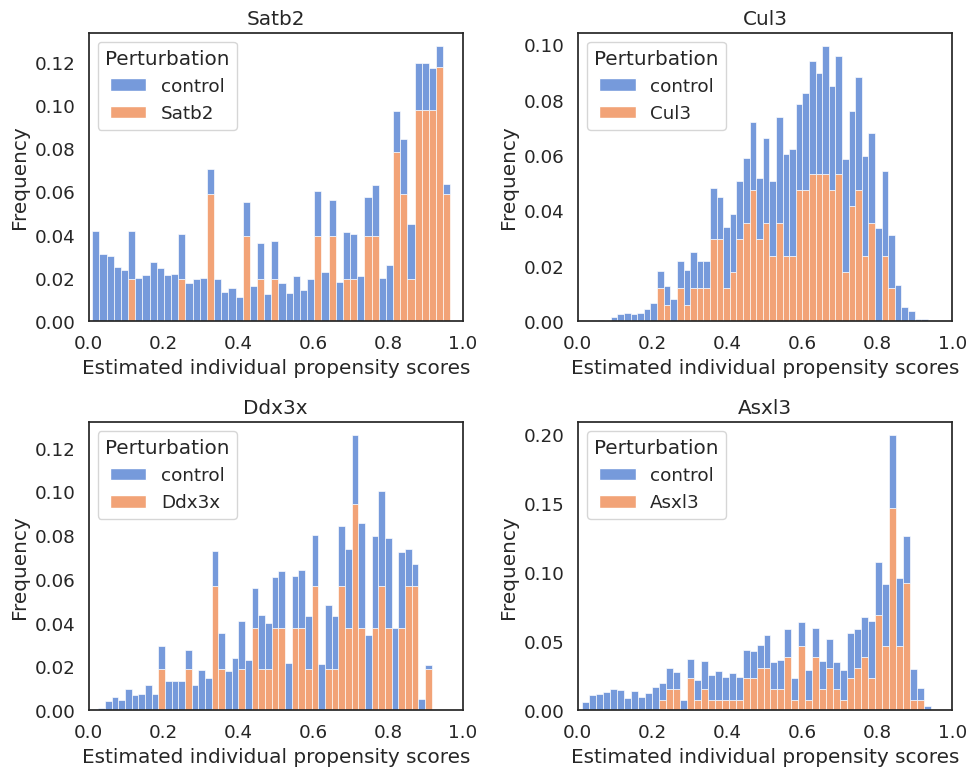

In [ ]:
sns.set(font_scale=1.2, style="white")
fig, axes = plt.subplots(2,2,figsize=(10,8))
for i in range(2):
    for j in range(2):
        pert = discovery_counts['Perturbation'][i*2+j]
        a = np.where(A.columns == pert)[0][0]
        _df = pd.DataFrame({
            'value': estimation['pi_hat'][:,a],
            'Perturbation': ['control' if i==0 else pert for i in A.values[:,a]]
        })
        sns.histplot(data=_df, x='value', hue="Perturbation",  common_norm=False,
            multiple='stack', palette='muted', bins=50, stat="probability", ax=axes[i,j])
        axes[i,j].set_xlim([0,1])
        axes[i,j].set_xlabel('Estimated individual propensity scores')
        axes[i,j].set_ylabel('Frequency')
        axes[i,j].set_title(f'{pert}')
fig.tight_layout()
fig.savefig('perturbseq-ps.pdf', bbox_inches='tight', dpi=300)

We observe extreme values only for *Satb2*, which could lead to slightly overconfident estimates. Overall, the distributions of propensity scores are reasonable for most perturbation conditions.